# Text-to-Image and Image-to-Image Search Using CLIP
Tutorial from https://www.pinecone.io/learn/clip-image-search/

## Import libraries

In [1]:
import torch
import random
import requests
import pandas as pd
from PIL import Image
import pinecone
from io import BytesIO
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from sklearn.metrics.pairwise import cosine_similarity

/Users/sebastianwiesner/Documents/GitHub/pinecone/.venv/lib/python3.11/site-packages/pinecone/index.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Load Data

In [2]:
# Data acquisition, 3.3M images with two main columns, image url and image caption
image_data = load_dataset("conceptual_captions", split="train")

No config specified, defaulting to: conceptual_captions/unlabeled
Found cached dataset conceptual_captions (/Users/sebastianwiesner/.cache/huggingface/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8)


In [3]:
# Define number of rows in dataset
num_ds = 500

# Save a set of 300 images (only url and caption) in a dataframe 
image_data_df = pd.DataFrame(image_data[:num_ds])
image_data_df.head()

image_url  \
0  http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...   
1  http://78.media.tumblr.com/3b133294bdc7c7784b7...   
2  https://media.gettyimages.com/photos/young-con...   
3  https://thumb1.shutterstock.com/display_pic_wi...   
4  https://thumb1.shutterstock.com/display_pic_wi...   

                                             caption  
0                         a very typical bus station  
1  sierra looked stunning in this top and this sk...  
2  young confused girl standing in front of a war...  
3  interior design of modern living room with fir...  
4    cybernetic scene isolated on white background .

## Prepare Data

In [4]:
def check_valid_URLs(image_URL):
  """
  Function which checks if the image URL is valid, returns true or false value
  """
  try:
    response = requests.get(image_URL)
    Image.open(BytesIO(response.content))
    return True
  except:
    return False

In [5]:
def get_image(image_URL):
    """
    Function which returns the image to a given image URL
    """
    response = requests.get(image_URL)
    image = Image.open(BytesIO(response.content)).convert("RGBA")
    return image

In [6]:
def get_image_caption(image_ID):
    """
    Function which returns the caption of an given image ID
    """
    return image_data[image_ID]["caption"]

In [7]:
# Check if URL is valid or not, add column is_valid with True or False values
image_data_df["is_valid"] = image_data_df["image_url"].apply(check_valid_URLs)
image_data_df.head()

image_url  \
0  http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...   
1  http://78.media.tumblr.com/3b133294bdc7c7784b7...   
2  https://media.gettyimages.com/photos/young-con...   
3  https://thumb1.shutterstock.com/display_pic_wi...   
4  https://thumb1.shutterstock.com/display_pic_wi...   

                                             caption  is_valid  
0                         a very typical bus station      True  
1  sierra looked stunning in this top and this sk...      True  
2  young confused girl standing in front of a war...      True  
3  interior design of modern living room with fir...      True  
4    cybernetic scene isolated on white background .      True

In [8]:
# Only keep rows with is_valid == True, hence remove invalid image URLs
image_data_df = image_data_df[image_data_df["is_valid"]==True]
image_data_df.head()

image_url  \
0  http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...   
1  http://78.media.tumblr.com/3b133294bdc7c7784b7...   
2  https://media.gettyimages.com/photos/young-con...   
3  https://thumb1.shutterstock.com/display_pic_wi...   
4  https://thumb1.shutterstock.com/display_pic_wi...   

                                             caption  is_valid  
0                         a very typical bus station      True  
1  sierra looked stunning in this top and this sk...      True  
2  young confused girl standing in front of a war...      True  
3  interior design of modern living room with fir...      True  
4    cybernetic scene isolated on white background .      True

In [9]:
# Add the actual image to row "image" using the image url
image_data_df["image"] = image_data_df["image_url"].apply(get_image)
image_data_df.head()

image_url  \
0  http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...   
1  http://78.media.tumblr.com/3b133294bdc7c7784b7...   
2  https://media.gettyimages.com/photos/young-con...   
3  https://thumb1.shutterstock.com/display_pic_wi...   
4  https://thumb1.shutterstock.com/display_pic_wi...   

                                             caption  is_valid  \
0                         a very typical bus station      True   
1  sierra looked stunning in this top and this sk...      True   
2  young confused girl standing in front of a war...      True   
3  interior design of modern living room with fir...      True   
4    cybernetic scene isolated on white background .      True   

                                               image  
0  <PIL.Image.Image image mode=RGBA size=800x534 ...  
1  <PIL.Image.Image image mode=RGBA size=500x441 ...  
2  <PIL.Image.Image image mode=RGBA size=490x612 ...  
3  <PIL.Image.Image image mode=RGBA size=450x470 ...  
4  <PIL.Image.Image image mode=RGBA size=450x470 ...

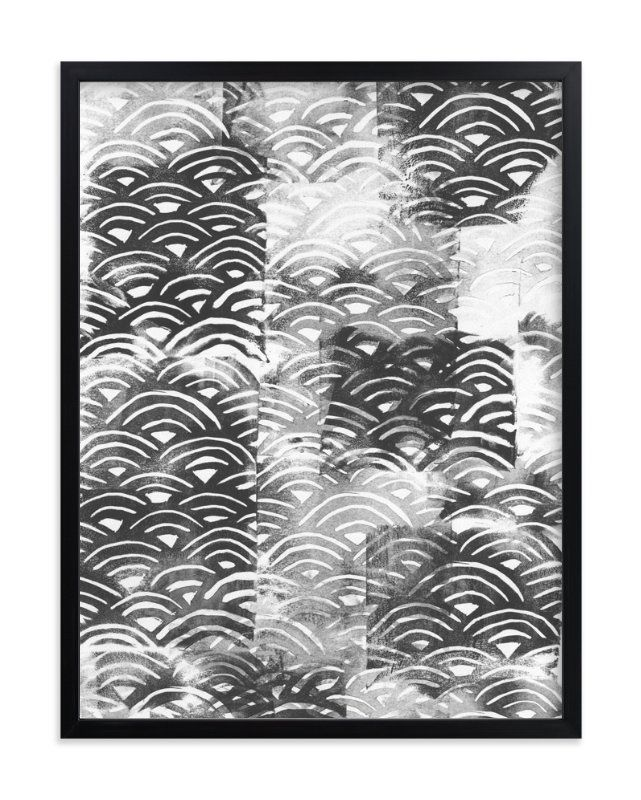

In [10]:
# Display random image
image_data_df.iloc[random.randint(1, num_ds - 1)]["image"]

In [11]:
def get_model_info(model_ID, device):
  """
  Functio to define Model, processor and tokenizer.
  Prerequisites to implement the encoder.
  """

  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)

  # Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)

  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)

  # Return model, processor & tokenizer
  return model, processor, tokenizer

In [12]:
# Save the device, prefered cuda
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model ID
model_ID = "openai/clip-vit-base-patch32"

# Store values from the function for model, processor and tokenizer given Model id and device
model, processor, tokenizer = get_model_info(model_ID, device)

## Create Embeddings: Text and Image Embeddings

### Text Embeddings

In [13]:
def get_single_text_embedding(text):
  """
  Function which generates the embedding of a single text
  """
  
  # Uses tokenizer to convert the text input into tokenized format.
  # Tokenizer converts the text into a format suitable for the underlying model.
  # Return_tensors="pt" parameter specifies that the output should be returned as PyTorch tensors.
  inputs = tokenizer(text, return_tensors = "pt")

  # Passes the tokenized text as input to a model's get_text_features.
  # Method generates embeddings or features for the given text.
  # **inputs syntax is used to unpack the dictionary-like inputs object and pass its contents as keyword arguments to the get_text_features method.
  text_embeddings = model.get_text_features(**inputs)

  # convert the embeddings to numpy array
  # .cpu() method moves the tensor to the CPU (if it was on a GPU device).
  # .detach() method creates a new tensor that does not require gradients (useful for intermediate results).
  embedding_as_np = text_embeddings.cpu().detach().numpy()

  return embedding_as_np

In [14]:
def get_all_text_embeddings(df, text_col):
   """
   Function which gets text embeddings for a whole df
   """
   # Apply get_single_text_embedding to every row
   df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)
   return df

In [15]:
# Apply get_all_text_embeddings to default df
image_data_df = get_all_text_embeddings(image_data_df, "caption")
image_data_df.head()

image_url  \
0  http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...   
1  http://78.media.tumblr.com/3b133294bdc7c7784b7...   
2  https://media.gettyimages.com/photos/young-con...   
3  https://thumb1.shutterstock.com/display_pic_wi...   
4  https://thumb1.shutterstock.com/display_pic_wi...   

                                             caption  is_valid  \
0                         a very typical bus station      True   
1  sierra looked stunning in this top and this sk...      True   
2  young confused girl standing in front of a war...      True   
3  interior design of modern living room with fir...      True   
4    cybernetic scene isolated on white background .      True   

                                               image  \
0  <PIL.Image.Image image mode=RGBA size=800x534 ...   
1  <PIL.Image.Image image mode=RGBA size=500x441 ...   
2  <PIL.Image.Image image mode=RGBA size=490x612 ...   
3  <PIL.Image.Image image mode=RGBA size=450x470 ...   
4  <PIL.Image.Image image mode=RGBA size=450x470 ...   

                                     text_embeddings  
0  [[0.25922298, -0.08825964, 0.020317197, -0.127...  
1  [[0.004146844, 0.18943518, -0.12396961, 0.3029...  
2  [[-0.28738007, -0.3481406, -0.042885076, 0.401...  
3  [[0.5606451, -0.15138105, -0.43740284, -0.3392...  
4  [[0.035291567, 0.24262652, -0.12724844, -0.210...

### Image Embeddings

In [16]:
def get_single_image_embedding(my_image):
  """
  Function which generates the embedding of a single image
  """
  
  # Uses processor to preprocess the my_image input.
  # Returns a dictionary-like object. 
  # text=None argument indicates that there is no associated text for the image.
  # images=my_image argument provides the image data to be processed.
  # return_tensors="pt" argument specifies that the output should be returned as PyTorch tensors.
  # ["pixel_values"] retrieves the tensor containing the pixel values from the returned dictionary-like object.
  # .to(device) moves the tensor to a specified device (e.g., GPU) if one is specified.
  image = processor(
    text = None,
    images = my_image, 
    return_tensors="pt"
  )["pixel_values"].to(device)

  # Passes the preprocessed image tensor, image, as input to a model's get_image_features method.
  # Method generates embeddings or features for the given image
  embedding = model.get_image_features(image)

  # Converts the tensor-based embedding to a NumPy array.
  # .cpu() method moves the tensor to the CPU (if it was on a GPU device).
  # .detach() method creates a new tensor that does not require gradients (useful for intermediate results).
  embedding_as_np = embedding.cpu().detach().numpy()

  return embedding_as_np

In [17]:
def get_all_images_embedding(df, img_column):
  """
  Function which gets image embeddings for a whole df
  """
  # Apply get_single_image_embedding to every row
  df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)
  return df

In [18]:
# Apply get_all_images_embedding to default df
image_data_df = get_all_images_embedding(image_data_df, "image")
image_data_df.head()

image_url  \
0  http://lh6.ggpht.com/-IvRtNLNcG8o/TpFyrudaT6I/...   
1  http://78.media.tumblr.com/3b133294bdc7c7784b7...   
2  https://media.gettyimages.com/photos/young-con...   
3  https://thumb1.shutterstock.com/display_pic_wi...   
4  https://thumb1.shutterstock.com/display_pic_wi...   

                                             caption  is_valid  \
0                         a very typical bus station      True   
1  sierra looked stunning in this top and this sk...      True   
2  young confused girl standing in front of a war...      True   
3  interior design of modern living room with fir...      True   
4    cybernetic scene isolated on white background .      True   

                                               image  \
0  <PIL.Image.Image image mode=RGBA size=800x534 ...   
1  <PIL.Image.Image image mode=RGBA size=500x441 ...   
2  <PIL.Image.Image image mode=RGBA size=490x612 ...   
3  <PIL.Image.Image image mode=RGBA size=450x470 ...   
4  <PIL.Image.Image image mode=RGBA size=450x470 ...   

                                     text_embeddings  \
0  [[0.25922298, -0.08825964, 0.020317197, -0.127...   
1  [[0.004146844, 0.18943518, -0.12396961, 0.3029...   
2  [[-0.28738007, -0.3481406, -0.042885076, 0.401...   
3  [[0.5606451, -0.15138105, -0.43740284, -0.3392...   
4  [[0.035291567, 0.24262652, -0.12724844, -0.210...   

                                      img_embeddings  
0  [[-0.003400065, -0.05358524, 0.35247576, 0.331...  
1  [[-0.25020325, -0.13257739, 0.09706184, 0.9788...  
2  [[-0.39855862, 0.29502586, -0.119867, 0.334940...  
3  [[-0.16011223, -0.2958299, -0.11380547, -0.048...  
4  [[0.18214476, 0.050187632, -0.64188623, -0.079...

## Plot Images Functions

In [19]:
def plot_images(images):
  """
  Helper functio to plot images
  """

  for image in images:
    plt.imshow(image)
    plt.show()

In [20]:
def plot_images_by_side(top_images):
  """
  Helper function for side-by-side visualization of recommended images. Each image has caption and similarity score.
  """

  index_values = list(top_images.index.values)
  list_images = [top_images.iloc[idx].image for idx in index_values] 
  list_captions = [top_images.iloc[idx].caption for idx in index_values] 
  similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values] 

  n_row = n_col = 2

  _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
  axs = axs.flatten()
  for img, ax, caption, sim_score in zip(list_images, axs, list_captions, similarity_score):
      ax.imshow(img)
      sim_score = 100*float("{:.2f}".format(sim_score))
      ax.title.set_text(f"Caption: {caption}\nSimilarity: {sim_score}%")
  plt.show()

## Plot Images Functions
Cosine Similarity Search

In [21]:
def get_top_N_images(query, data, top_K=4, search_criterion="text"):
    """
    Function retrieves the embedding vector for the query (either text or image).
    Calculates the cosine similarity between the query vector and the embedding vectors in the data DataFrame.
    Sorts the DataFrame based on similarity.
    Selects the top K similar articles.
    Returns a DataFrame containing the relevant columns for those articles.
    """

    # Text to image Search, call get_single_text_embedding for a single text
    if(search_criterion.lower() == "text"):
      query_vect = get_single_text_embedding(query)

    # Image to image Search, call get_single_image_embedding function for a single image
    else: 
      query_vect = get_single_image_embedding(query)

    # Relevant columns
    revevant_cols = ["caption", "image", "cos_sim"]
    
    # Run similarity Search
    # Calculate the cosine similarity between the query_vect and each embedding vector.
    # Apply method is used to apply cosine_similarity function to each element of the "img_embeddings" column.
    # Resulting similarities are stored in a new column named "cos_sim".
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))

    # Extracts the similarity values from the resulting 2D array
    # Keeping only the first element (since cosine_similarity returns a nested list with a single value).
    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])

    
    # Sort Cosine Similarity Column in Descending Order 
    # Here we start at 1 to remove similarity with itself because it is always 1
    most_similar_articles = data.sort_values(by='cos_sim', ascending=False)[1:top_K+1]
    
    # Returns the most_similar_articles DataFrame
    # Only with the columns specified in relevant_cols
    # Reset_index() method is called to reset the index, providing a new sequential index.
    return most_similar_articles[revevant_cols].reset_index()

### Text to Image Search

In [22]:
# Retrieve caption for similarity search
query_caption = image_data_df.iloc[random.randint(1, num_ds - 1)].caption

# Calls get_top_N_images, passing query_caption and the image_data_df
top_images = get_top_N_images(query_caption, image_data_df)

# Print searched caption
print("Query: {}".format(query_caption))

# Print dataframe
top_images

Query: this year we 're bringing you even more halloween costume ideas for guys with beards and mustaches !


index                                            caption  \
0    253            hipster cat in a hat and with glasses .   
1    366  an overview of 1950s fashion is featured , wit...   
2    124  fit man stretching and listening to music by t...   
3    338  yellow pumpkin with a bow in the pants and sho...   

                                               image   cos_sim  
0  <PIL.Image.Image image mode=RGBA size=450x470 ...  0.264327  
1  <PIL.Image.Image image mode=RGBA size=620x449 ...  0.260421  
2  <PIL.Image.Image image mode=RGBA size=612x408 ...  0.258897  
3  <PIL.Image.Image image mode=RGBA size=600x552 ...  0.254144

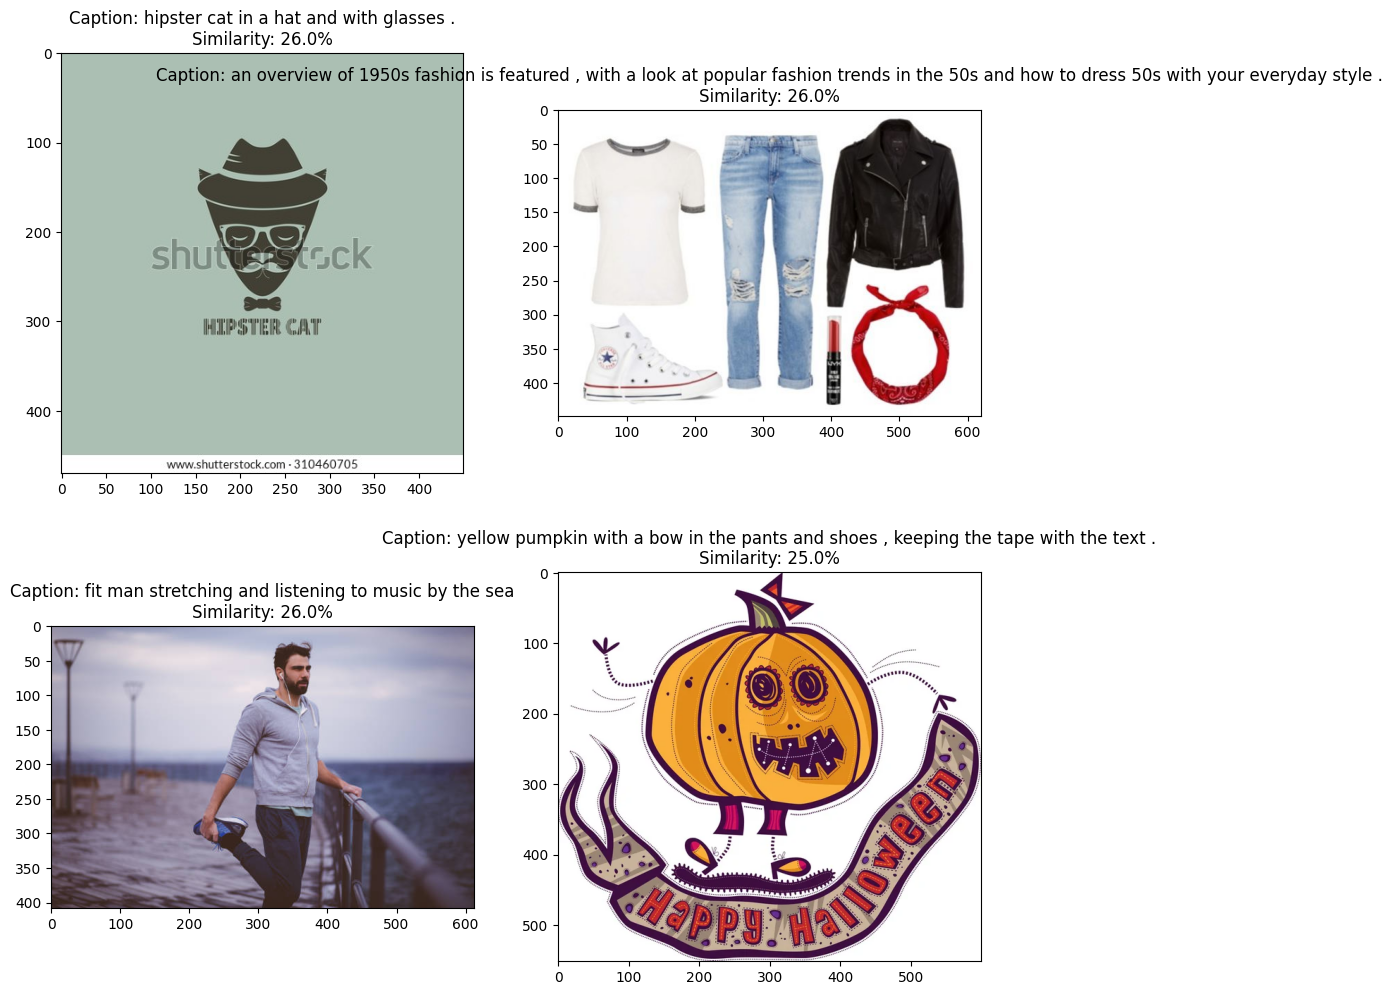

In [23]:
# Plot the 4 images
plot_images_by_side(top_images)

### Image to image search

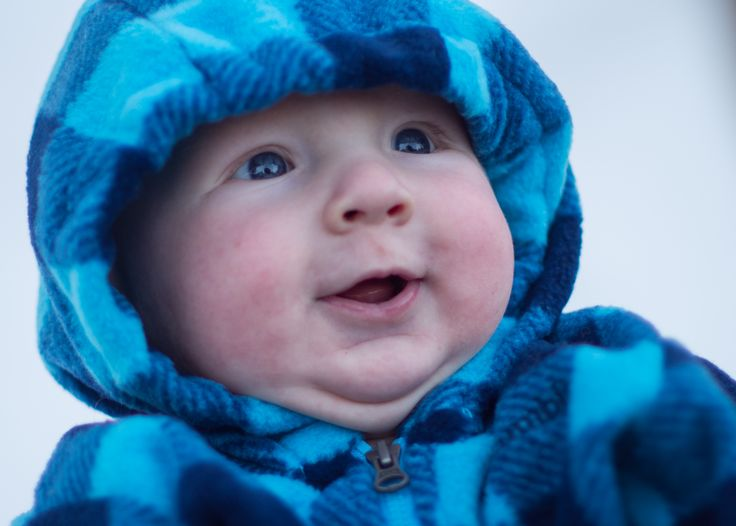

In [24]:
# Retrieve caption for similarity search, this time using the image
query_image = image_data_df.iloc[random.randint(1, num_ds - 1)].image
query_image

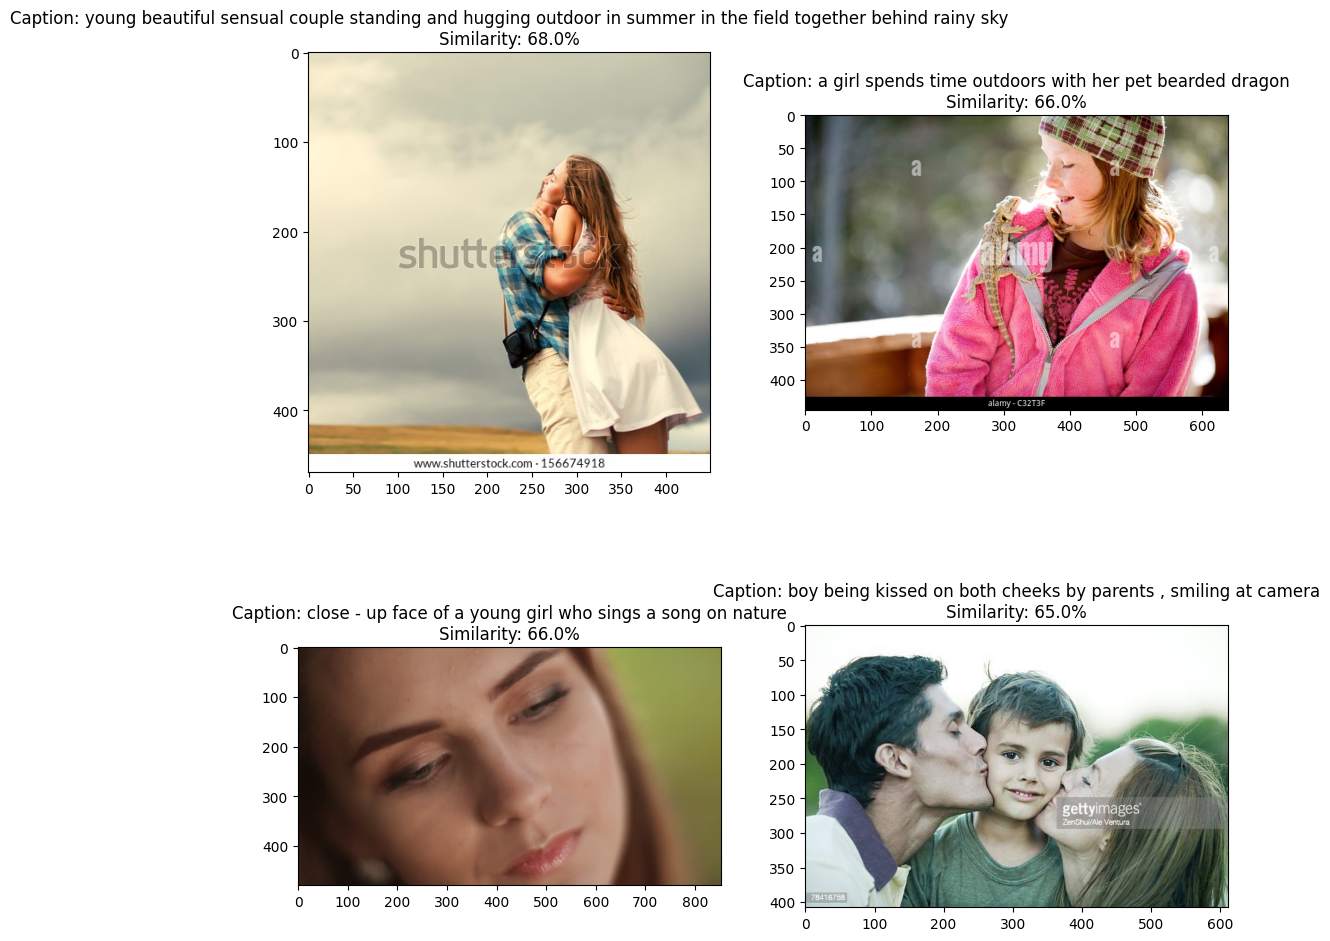

In [25]:
# Calls get_top_N_images, passing query_caption and the image_data_df
top_images = get_top_N_images(query_image, image_data_df, search_criterion="image")

# Print dataframe
plot_images_by_side(top_images)

## Pinecone Client Library
Pinecone provides a fully-managed, easily scalable vector database that makes it easy to build high-performance vector search applications.

In [26]:
pinecone.init(
    api_key = "86378080-7c27-464a-acbb-9e83d7455bcb", 
    environment="northamerica-northeast1-gcp"
)

my_index_name = "clip-image-search"

#Get dimension of the vector (512)
vector_dim = image_data_df.img_embeddings[0].shape[1]

if my_index_name not in pinecone.list_indexes():
  # Create the vectors dimension
  pinecone.create_index(name = my_index_name, 
                        dimension=vector_dim, 
                        metric="cosine", shards=1,
                        pod_type='s1.x1')

In [27]:
# Connect to the index
my_index = pinecone.Index(index_name = my_index_name)
my_index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 84}},
 'total_vector_count': 84}

### Populate the database

In [28]:
# Add column vector id as string
image_data_df["vector_id"] = image_data_df.index.astype(str)

# Get all the metadata
final_metadata = []

#Store ID, caption and image as dict in a list
for index in range(len(image_data_df)):
  final_metadata.append({
    'ID':  index,
    'caption': image_data_df.iloc[index].caption, 
    'image': image_data_df.iloc[index].image_url
})

# Store Vector IDs as a list
image_IDs = image_data_df.vector_id.tolist()

# Store image embeddings as list
image_embeddings = [arr.tolist() for arr in image_data_df.img_embeddings.tolist()]

# Create the single list of dictionary format to insert 
data_to_upsert = list(zip(image_IDs, image_embeddings, final_metadata))

# Upload the final data
my_index.upsert(vectors = data_to_upsert)

# Check index size for each namespace
my_index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 416}},
 'total_vector_count': 416}

### Helper Function for creating Data Frame out of Pinecone Results

In [29]:
def process_pinecone_output(output, image_to_image = False):
    # Create empty dict for values from the pinecone output
    data = {'id': [], 'caption': [], 'image_url': [], 'cos_sim': []}
    for match in output['matches']:
        data['id'].append(match['id'])
        data['caption'].append(match['metadata']['caption'])
        data['image_url'].append(match['metadata']['image'])
        data['cos_sim'].append(match['score'])

    # Convert data dict into dataframe
    top_images = pd.DataFrame(data)
    
    # Get actual images from URLs
    top_images["image"] = top_images["image_url"].apply(get_image)

    if image_to_image == True:
        # Drop first column since its the same image
        top_images = top_images.drop(0)
        top_images = top_images.reset_index(drop=True)
        return top_images
    else:
        return top_images

### Text to Image Search

Query: old fishing boats beached on a coastal beach in countryside


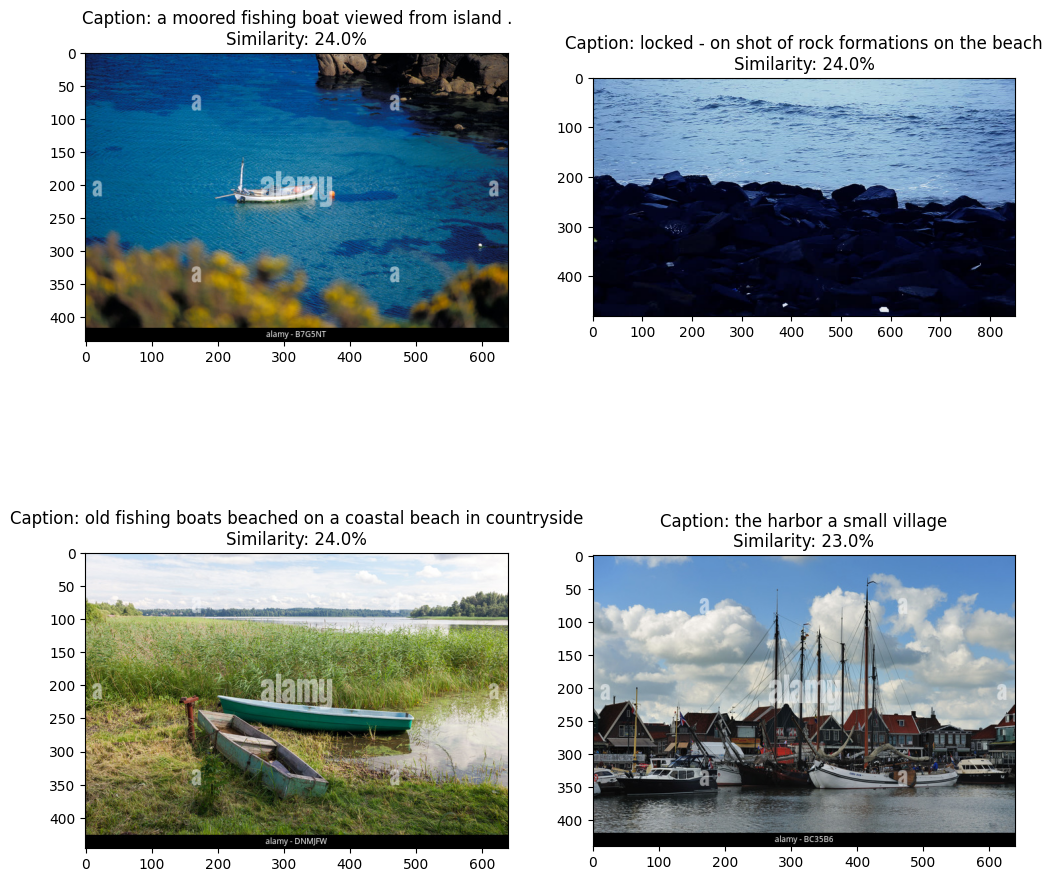

In [31]:
# Retrieve caption for similarity search
text_query = image_data_df.iloc[random.randint(1, num_ds - 1)].caption

# Get the caption embedding
query_embedding = get_single_text_embedding(text_query).tolist()


# Print the caption
print("Query: {}".format(text_query))

# Run the query
output = my_index.query(query_embedding, top_k=4, include_metadata=True)

# Print dataframe
top_images = process_pinecone_output(output)
plot_images_by_side(top_images)

### Image to Image Search

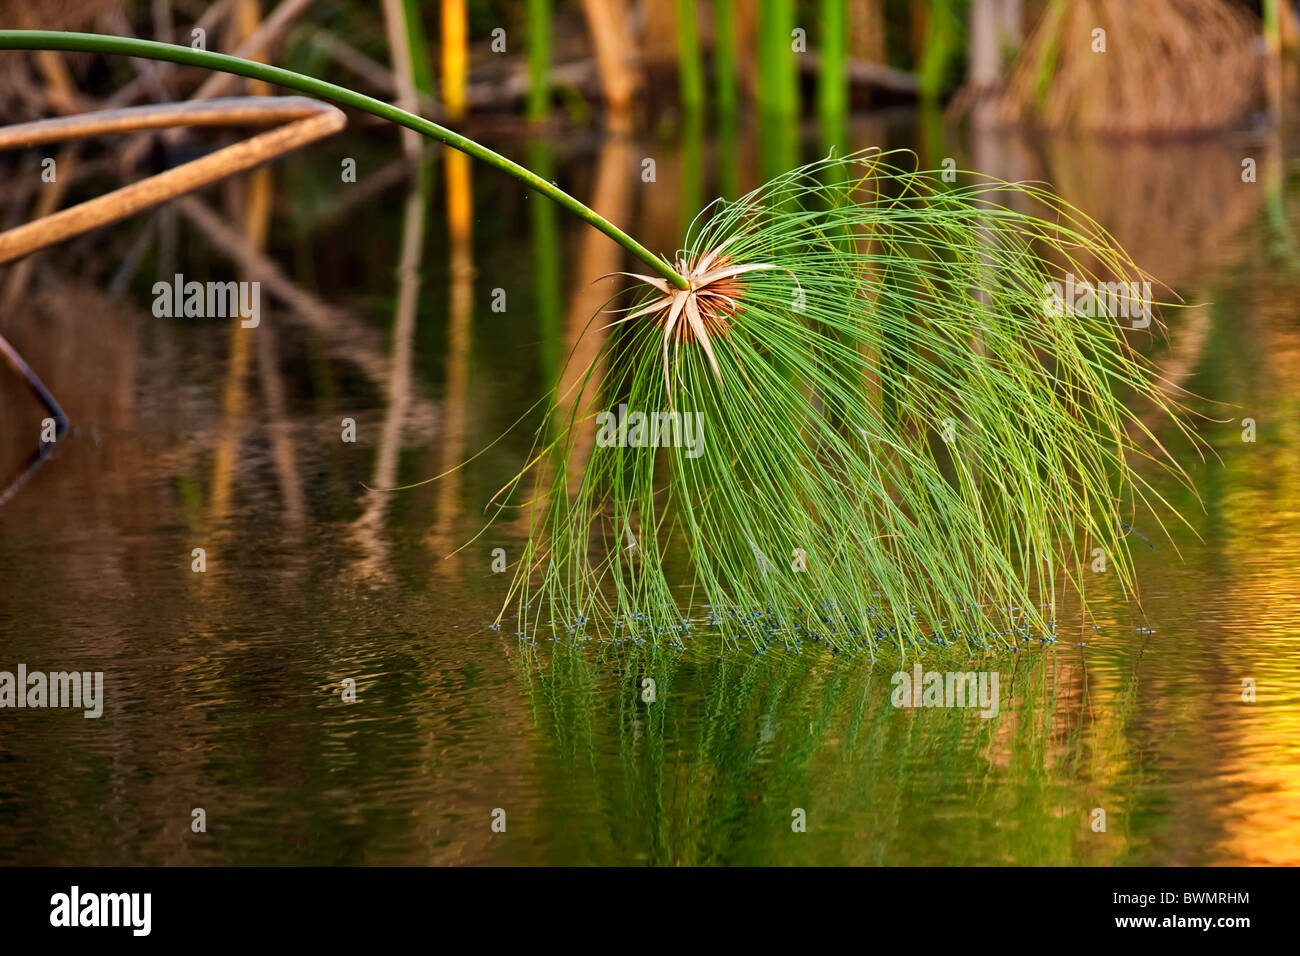

In [32]:
# Retrieve caption for similarity search, this time using the image
query_image = image_data_df.iloc[random.randint(1, num_ds - 1)].image
query_image

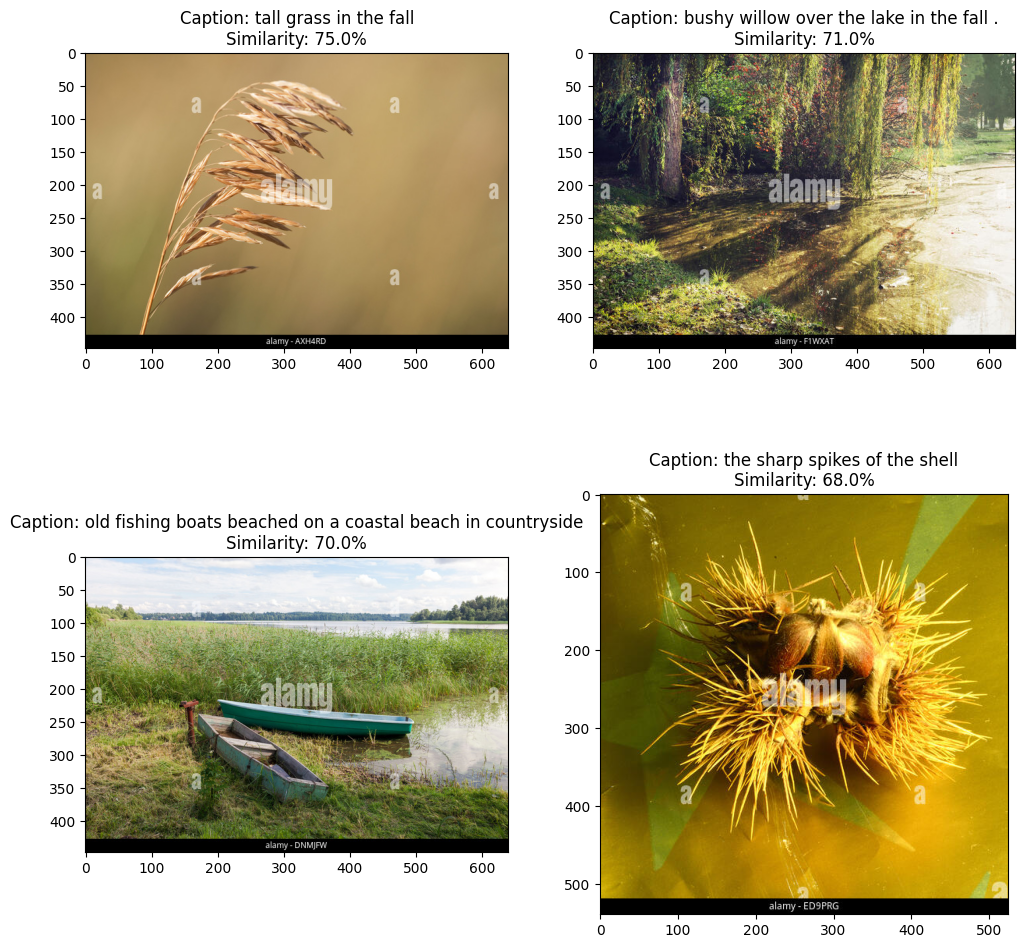

In [33]:
# Get the text embedding
query_embedding = get_single_image_embedding(query_image).tolist()

# Run the Image to Image query
output = my_index.query(query_embedding, top_k=5, include_metadata=True)

# Print dataframe
top_images = process_pinecone_output(output, image_to_image=True)
plot_images_by_side(top_images)